In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as pt
from matplotlib.collections import LineCollection
import numpy.linalg as la
from scipy.stats import multivariate_normal

In [4]:
with open('faithful.dat.txt') as f:
    lines = f.read().splitlines()
data = []
begin_parse = False
for line in lines:
    if line == '    eruptions waiting':
        begin_parse = True
        continue
    if begin_parse:
        tokens = line.split()
        features = []
        features.append(float(tokens[1]))
        features.append(float(tokens[2]))
        data.append(features)
data = np.array(data)

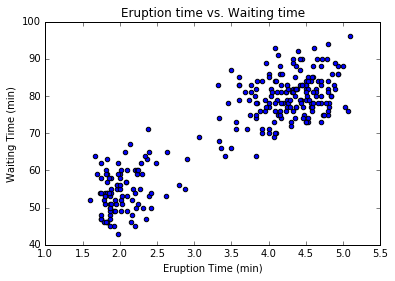

In [5]:
pt.figure()
pt.scatter(data[:,0], data[:,1])
pt.title("Eruption time vs. Waiting time")
pt.xlabel("Eruption Time (min)")
pt.ylabel("Waiting Time (min)")
pt.show()

In [6]:
#Preprocess
N = len(data)

x_max = max(data[:,0])
x_min = min(data[:,0])

y_max = max(data[:,1])
y_min = min(data[:,1])

data_scaled = np.copy(data)
for i in range(N):
    data_scaled[i,0] = (data_scaled[i,0] - x_min)/(x_max - x_min)
    data_scaled[i,1] = (data_scaled[i,1] - y_min)/(y_max - y_min)

544


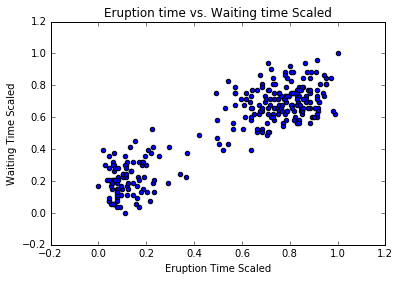

In [19]:
print (data_scaled.size)

pt.figure()
pt.scatter(data_scaled[:,0], data_scaled[:,1])
pt.title("Eruption time vs. Waiting time Scaled")
pt.xlabel("Eruption Time Scaled")
pt.ylabel("Waiting Time Scaled")
pt.show()

In [13]:
#Step 1: Initial
mu_1 = np.array([.1, .2])
sigma_1 = np.identity(2)
mu_2 = np.array([.8,.7])
sigma_2 = np.identity(2)
pi = 0.5

print (N)

272


In [14]:
def phi(x, mu, sigma):
    return multivariate_normal.pdf(x, mu, sigma)

In [15]:
#Step 2: Compute Responsibilities
def compute_responsibilities(mu_1, sigma_1, mu_2, sigma_2, pi):
    gammas = np.zeros(N)
    for i in range(N):
        gamma = (pi * phi(data_scaled[i,:], mu_2, sigma_2)) / ((1 - pi) * phi(data_scaled[i,:], mu_1, sigma_1) + pi * phi(data_scaled[i,:], mu_2, sigma_2))
        gammas[i] = gamma
    return gammas

In [16]:
#Step 3: Recompute Mean and Variances
def update_means(mu_1, sigma_1, mu_2, sigma_2, pi):
    gammas = compute_responsibilities(mu_1, sigma_1, mu_2, sigma_2, pi)
    
    mu_1_0 = sum((1 - gammas) * data_scaled[:,0])
    mu_1_1 = sum((1 - gammas) * data_scaled[:,1])
    mu_1_new = np.array([mu_1_0, mu_1_1])
    mu_1_new = mu_1_new / float(sum(1 - gammas))
    
    mu_2_0 = sum(gammas * data_scaled[:,0])
    mu_2_1 = sum(gammas * data_scaled[:,1])
    mu_2_new = np.array([mu_2_0, mu_2_1])
    mu_2_new = mu_2_new / float(sum(gammas))
    
    s_sigma_1 = np.zeros((2,2))
    for i in range(N):
        s_sigma_1 += (1 - gammas[i]) * (data_scaled[i,:] - mu_1_new).dot((data_scaled[i,:] - mu_1_new).T)
    s_sigma_1 = s_sigma_1 / float(sum(1 - gammas))
    sigma_1_new = s_sigma_1 * np.identity(2)
    
    s_sigma_2 = np.zeros((2,2))
    for i in range(N):
        s_sigma_2 += gammas[i] * (data_scaled[i,:] - mu_2_new).dot((data_scaled[i,:] - mu_2_new).T)
    s_sigma_2 = s_sigma_2 / float(sum(gammas))
    sigma_2_new = s_sigma_2 * np.identity(2)
    
    pi_new = sum(gammas) / float(N)
    
    return mu_1_new, sigma_1_new, mu_2_new, sigma_2_new, pi_new

In [17]:
#Step 4: Iterate until Convergence
mu_1 = np.array([.1, .2])
sigma_1 = np.identity(2)
mu_2 = np.array([.9,.8])
sigma_2 = np.identity(2)
pi = 0.5

trajectory_mu_1 = []
trajectory_mu_2 = []

#%Diff is < 1e-5

trajectory_mu_1.append(mu_1)
trajectory_mu_2.append(mu_2)
for i in range(50):
    mu_1_prev = mu_1
    mu_2_prev = mu_2
    
    mu_1, sigma_1, mu_2, sigma_2, pi = update_means(mu_1, sigma_1, mu_2, sigma_2, pi)
    trajectory_mu_1.append(mu_1)
    trajectory_mu_2.append(mu_2)
    
    if la.norm(mu_1 - mu_1_prev) < 1e-5 and la.norm(mu_2 - mu_2_prev) < 1e-5:
        break

In [20]:
trajectory_mu_1 = np.array(trajectory_mu_1)
trajectory_mu_2 = np.array(trajectory_mu_2)

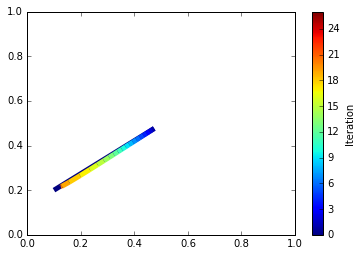

In [21]:
z = np.arange(len(trajectory_mu_1))
fig = pt.figure()
ax = pt.axes()
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
points = np.array([trajectory_mu_1[:,0], trajectory_mu_1[:,1]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments)
lc.set_array(z)
lc.set_linewidth(5)
pt.gca().add_collection(lc)
axcb = fig.colorbar(lc)
axcb.set_label('Iteration')
pt.show()

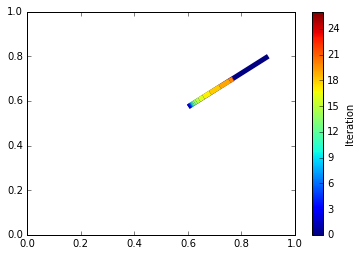

In [22]:
z = np.arange(len(trajectory_mu_2))
fig = pt.figure()
ax = pt.axes()
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
points = np.array([trajectory_mu_2[:,0], trajectory_mu_2[:,1]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments)
lc.set_array(z)
lc.set_linewidth(5)
pt.gca().add_collection(lc)
axcb = fig.colorbar(lc)
axcb.set_label('Iteration')
pt.show()

In [26]:
#50 Random initializations
iterations = []
for j in range(50):
    mu_1 = np.random.random(2)
    sigma_1 = np.identity(2)
    mu_2 = np.random.random(2)
    sigma_2 = np.identity(2)
    pi = 0.5

    #%Diff is < 1e-5
    iteration = 0
    while True:
        mu_1_prev = mu_1
        mu_2_prev = mu_2

        mu_1, sigma_1, mu_2, sigma_2, pi = update_means(mu_1, sigma_1, mu_2, sigma_2, pi)

        iteration += 1
        if la.norm(mu_1 - mu_1_prev) < 1e-5 and la.norm(mu_2 - mu_2_prev) < 1e-5:
            iterations.append(iteration)
            break
print (iterations)

KeyboardInterrupt: 

In [ ]:
#K-Means
def k_means():
    c = np.random.randint(0,2,272)
    m_0 = np.zeros(2)
    m_1 = np.zeros(2)
    for j in range(5):
        m_0 = np.zeros(2)
        m_1 = np.zeros(2)
        for i in range(272):
            if c[i] == 0:
                m_0 += data_scaled[i,:]
            else:
                m_1 += data_scaled[i,:]
        m_0 = m_0 / float(272 - sum(c))
        m_1 = m_1 / float(sum(c))
        for i in range(272):
            if la.norm(data_scaled[i,:] - m_0) < la.norm(data_scaled[i,:] - m_1):
                c[i] = 0
            else:
                c[i] = 1
    #Achieved stability; calculate variance and pi
    sig_0 = np.identity(2)
    sig_1 = np.identity(2)
    sig_0_coeff = 0
    sig_1_coeff = 0
    for k in range(272):
        if c[k] == 0:
            sig_0_coeff += la.norm(data_scaled[k,:] - m_0)
        else:
            sig_1_coeff += la.norm(data_scaled[k,:] - m_1)
    sig_0_coeff = sig_0_coeff / float(272 - sum(c))
    sig_1_coeff = sig_1_coeff / float(sum(c))    
    sig_0 = sig_0_coeff * sig_0
    sig_1 = sig_1_coeff * sig_1
    pi_ = sum(c) / float(272)
    return m_0, sig_0, m_1, sig_1, pi_

In [24]:
#50 Random initializations
iterations = []
for j in range(50):

    mu_1, sigma_1, mu_2, sigma_2, pi = k_means()

    #%Diff is < 1e-5
    iteration = 0
    while True:
        mu_1_prev = mu_1
        mu_2_prev = mu_2

        mu_1, sigma_1, mu_2, sigma_2, pi = update_means(mu_1, sigma_1, mu_2, sigma_2, pi)

        iteration += 1
        if la.norm(mu_1 - mu_1_prev) < 1e-5 and la.norm(mu_2 - mu_2_prev) < 1e-5:
            iterations.append(iteration)
            break
print (iterations)

NameError: name 'k_means' is not defined

In [ ]:
pt.figure()
pt.hist(iterations)
pt.xlabel("Iterations")
pt.ylabel("Counts")
pt.title("Histogram of Number of Iterations Until Convergence Using K-Means Initializer")
pt.grid(True)
pt.show()